# Voronoi Diagram with Word Embedding

In this notebook, we will examine how to use word embedding and voronoi diagram to display the relationship between others words and a search term. Using Tale of Two Cities by Charles Dickens as the example (aquired from https://www.gutenberg.org/) we will showcase how the program words as well as explain different modification and steps that can be taken in the future

## Libraries and Resources used

-  Python 3
-  nltk
-  scipy
-  matplotlib
-  re (regex)
-  shapely
-  numpy 
-  gemsim

## Note:

For installation of the nessesary resources and libraries refer to their respective home page for installation steps for your operation system. 

The text being analysised (Tales of Two Cities by Charles Dicken) has some cleaning done to it beforehand. We have removed the sections that gutenberg documented (copyrights, etc) to simulate a more realistic corpus.

Written in Feburary 2018

## Importing the requried libraries

In [5]:
# Import Numpy
import numpy as np

# Import libraries for Voronoi Diagram
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.ops import polygonize
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point, Polygon

# Import nltk and cleaning libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Vectorization
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

## Loading the Corpus

We will start out by loading in the corpus and tokenizing the text by sentence using nltk. Depening on the corpus the result of this may be different (for example using a collection of tweets would result in a vastly different results as this notebook is not tailored for tweets)

In [6]:
# Read the text file
with open("A Tale of Two Cities.txt", "r", encoding = "utf-8") as f:
    TalesOfTwoCities = f.read()

# Tokenize the text by sentence
novelTokenSentence = sent_tokenize(TalesOfTwoCities)

# Display the first sentence
novelTokenSentence[0]

'\ufeff\n\nCONTENTS\n\n\n     Book the First--Recalled to Life\n\n     Chapter I      The Period\n     Chapter II     The Mail\n     Chapter III    The Night Shadows\n     Chapter IV     The Preparation\n     Chapter V      The Wine-shop\n     Chapter VI     The Shoemaker\n\n\n     Book the Second--the Golden Thread\n\n     Chapter I      Five Years Later\n     Chapter II     A Sight\n     Chapter III    A Disappointment\n     Chapter IV     Congratulatory\n     Chapter V      The Jackal\n     Chapter VI     Hundreds of People\n     Chapter VII    Monseigneur in Town\n     Chapter VIII   Monseigneur in the Country\n     Chapter IX     The Gorgon’s Head\n     Chapter X      Two Promises\n     Chapter XI     A Companion Picture\n     Chapter XII    The Fellow of Delicacy\n     Chapter XIII   The Fellow of no Delicacy\n     Chapter XIV    The Honest Tradesman\n     Chapter XV     Knitting\n     Chapter XVI    Still Knitting\n     Chapter XVII   One Night\n     Chapter XVIII  Nine Days\n  

## Cleaning the text

To help with some of the analysis we are going to clean the text. This is done by removing all punication, lowercasing all the words and finally lemmitizing them. This is help streamline and reduce variability when we train the model for word embedding.

### Cleaning Helper Functions

This function is what cleans the text. In this notebook we first convert the sentence to lowercase, followed by removing all the punctuation and finally lemmatize the remaining words. If there is any additional aspect or modification needed this is where you would add them.

In [7]:
# Declare a set of stopwords and puncation to remove
stopword_punctuation = set(stopwords.words('english') + list(string.punctuation))

# Initalize Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Cleaning function that cleans the sentence given to it
def cleanText(sentence):
    # Converts to lowercase
    sentence = sentence.lower()
    
    # tokenize the sentence
    sentence = word_tokenize(sentence)
    
    # Remove all the stopwords / punctuation 
    sentence = filter(lambda token: token not in stopword_punctuation, sentence)
    
    # Lemmatize each word
    sentence = list(map(wordnet_lemmatizer.lemmatize,sentence))
    
    return sentence

### Conducting the Cleaning

Now that we declared the helper function to clean the text it is time to clean the text.

#### Note:
That we are display the 2nd results. This is because the first result or element in the list is the chapter headings / index. Therefore for this notebook we chose to skip it to showcase an example from the text itself.

In [8]:
# Run the cleaning method on each element (sentence) in our novel
novelTextClean = list(map(cleanText, novelTokenSentence))

# Display 2nd results of the cleaning and the original before cleaning
print("This is the original: \n")
print(novelTokenSentence[1])
print("This is the clean: \n")
print(novelTextClean[1])

This is the original: 

The Period


It was the best of times,
it was the worst of times,
it was the age of wisdom,
it was the age of foolishness,
it was the epoch of belief,
it was the epoch of incredulity,
it was the season of Light,
it was the season of Darkness,
it was the spring of hope,
it was the winter of despair,
we had everything before us,
we had nothing before us,
we were all going direct to Heaven,
we were all going direct the other way--
in short, the period was so far like the present period, that some of
its noisiest authorities insisted on its being received, for good or for
evil, in the superlative degree of comparison only.
This is the clean: 

['period', 'best', 'time', 'worst', 'time', 'age', 'wisdom', 'age', 'foolishness', 'epoch', 'belief', 'epoch', 'incredulity', 'season', 'light', 'season', 'darkness', 'spring', 'hope', 'winter', 'despair', 'everything', 'u', 'nothing', 'u', 'going', 'direct', 'heaven', 'going', 'direct', 'way', '--', 'short', 'period', 'far', 

## Gathering Collocating Terms

Now that we have all the sentences tokenzied and cleaned, we can now do basic collocation. This is done by searching every sentence and finding if a desired word exist in that sentence. If it does we will add it to a new list of results. This is done so we can use word embedding later on to help vecotrize the result. For this example we will be looking for the term "city" in the text.

### Note:

Rememeber that all the tokens in the novel are in lowercase and lemmatized. Take this into account when choosing your search term.

In [9]:
# Function that find all sentences with the search term
def findSentence(word, novel):
    resultSet = []
    for sentence in novel:
        if word in sentence:
            resultSet.append(sentence)
    return resultSet

searchTerm = "city"

# We will store all the result of the term "city" into sentenceWithSearchTerm
sentenceWithSearchTerm = findSentence(searchTerm, novelTextClean)

## Word2Vec

Word2Vec is a machine learning model that produces word embeddings. From there we can use Principle Componenet Analysis (PCA) to convert these vectors into a 2d plane for the Voronoi Diagram. For additional information regarding Word2Vec,  word embedding, and PCA see https://en.wikipedia.org/wiki/Word2vec , https://en.wikipedia.org/wiki/Word_embedding, and https://en.wikipedia.org/wiki/Principal_component_analysis respectively. 

### Note:
This section used code that was taken/adapted from https://machinelearningmastery.com/develop-word-embeddings-python-gensim/ 

Also to reduce the amount of points found, we will only use words that appear more than 5 times. 

In [10]:
# train model using our results from earlier with words that appear atleast more than 5 times
Word2VecModel = Word2Vec(sentenceWithSearchTerm, min_count=5)

# save model for later use 
Word2VecModel.save('model.bin')

# load model
Word2VecModel = Word2Vec.load('model.bin')

# Store all the words in the model
VectorWords = list(Word2VecModel.wv.vocab)

# Access all of the vectors from a trained model 
vectorOfTrainedModel = Word2VecModel[Word2VecModel.wv.vocab]

# Initilize PCA
pca = PCA(n_components=2)

# Transform the data to 2D representation
Vector2DResults = pca.fit_transform(vectorOfTrainedModel)

# Display results
Vector2DResults

array([[-0.00378647, -0.0144499 ],
       [ 0.00421337,  0.00205862],
       [ 0.00786234,  0.01730623],
       [ 0.00039799, -0.00178626],
       [ 0.00430697, -0.00657699],
       [-0.01536589,  0.00378232],
       [ 0.0247497 , -0.00298003],
       [-0.00625652,  0.00932399],
       [-0.00384377,  0.0129755 ],
       [ 0.00588225, -0.00473138],
       [ 0.00738011,  0.00056366],
       [ 0.00350866, -0.01151074],
       [-0.00441971, -0.00670427],
       [-0.00013323,  0.00214137],
       [ 0.00517429,  0.00092954],
       [-0.0119135 , -0.0134993 ],
       [-0.00342053, -0.00297325],
       [-0.00170738,  0.0054751 ],
       [-0.00504164,  0.00737407],
       [-0.00758705,  0.0032817 ]], dtype=float32)

## Voronoi Diagram 
Now that we have the 2D representation of all the word embedding. We can now map them on a Voronoi Diagram. For additional inforamtion on what a voronoi diagram is see: https://en.wikipedia.org/wiki/Voronoi_diagram

### Note:
To create the voronoi diagram I have taken code from: 
https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647 and
https://stackoverflow.com/questions/34968838/python-finite-boundary-voronoi-cells

For additional information on modification to the following code please see the respective authors

## Defining Voronoi Functions

Function taken directly from: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


## Creating the Voronoi Diagram

Now that we declared the function to create the voronoi diagram, we need to plot it. Using shapely and matplotlib we now create a clipped Voronoi diagram. The reason for "clipped" is to create a more appealing diagram. There are case where the resulting voronoi diagram extends it borders to vastly empty region making the visulation less useful. Therefore we will attempt to trim down the borders of the diagram.

### Note:
The following code is adapted and taken from: https://stackoverflow.com/questions/34968838/python-finite-boundary-voronoi-cells

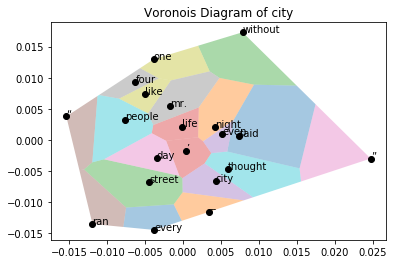

In [12]:
# Create the Voronoi from teh results
vor = Voronoi(Vector2DResults)

# plot the results of the voronoi 
regions, vertices = voronoi_finite_polygons_2d(vor)

# Create the point of the results
pts = MultiPoint([Point(i) for i in Vector2DResults])

# Create a mask for the ppoints
mask = pts.convex_hull.union(pts.buffer(10, resolution=50, cap_style=2))

# Creation of the new vertices and plotting the voronoi diagram
new_vertices = []

# For every region created from the model
for region in regions:
    
    # Get the shape of each region
    polygon = vertices[region]
    
    # Insert them into a list
    shape = list(polygon.shape)
    shape[0] += 1
    
    # Create and map the polygon 
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    
    # Add and fill in the polygon onto the plot
    new_vertices.append(poly)
    plt.fill(*zip(*poly), alpha=0.4)
    
# Plot the points of the vectorization
plt.plot(Vector2DResults[:,0], Vector2DResults[:,1], 'ko')

# Annotate the points
for i, txt in enumerate(VectorWords):
    plt.annotate(txt, (Vector2DResults[i][0],Vector2DResults[i][1]), fontsize = 10)

# Set the title of the diagram
plt.title("Voronois Diagram of " + searchTerm)

# Display the diagram
plt.show()

It is important to take notice that in the diagram there are points that are not words. Namely there are terms such as "“" or "--". The main reason why I did not remove them earlier is to demostrate that the cleaning (removing puncations and stop words) done eariler did not catch all cases. Therefore it is important to clean, manipulate, and customize the corpus to suit your needs. 

# Conclusion

In this notebook we have look at reading in a text file and cleaning it. Finding all the sentences that contained a particular term. Using word embedding and PCA converted the relationship the search term had with every other word in sentences that it appeared in to plot it in a Voronoi Diagram.